
# Lecture 2: Basic Optimization with PyTorch

# Table of Contents
- [Computational Graph](#graph)
- [Automatic Differentiation](#autodiff)
- [Regression](#linear)
- [Exercises](#exercises)


# Housekeeping
- We will need access to a gpu, install gpu pytorch or use colab
- Some references for today
  - [Official pytorch tutorials](https://pytorch.org/tutorials/)
  - [Pytorch tutorials by yunjey, from beginning to advanced](https://github.com/yunjey/pytorch-tutorial)
  - The chapter on machine learning basics, in [the deep learning book](https://www.deeplearningbook.org/contents/ml.html),
    in particular 5.1.4 goes through linear regression, and there's
    several nice sections expanding on the concepts if you haven't
    been through machine learning before (though it can be a bit
    abstract in parts)
- Today's url 
  - [https://git.io/2021deep02](https://git.io/ml2021-02)
- Ask during the exercise time today if you need help with any of this!

# Review

- We've looked at using the `numpy` and py`torch` packages
- We saw that `numpy` is a python library that allows us to use
  optimized libraries to manipulate numerical data in python
- We then saw that `torch` was similar but allowed us to go a step
  further by running on the GPU
- Today we'll look at the other aspect of `torch` that is important
  for us, its idea of using a *computational graph* for *automatic differentiation*

# Computational Graph <a id="graph"/>

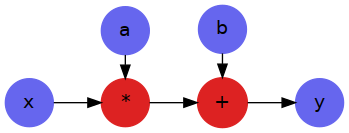

In [ ]:
x = torch.tensor([2])
a, b = torch.tensor([2]), torch.tensor([1])
y = a*x + b


- pytorch expressions don't just evaluate and discard intermediate values
- instead, a *computational graph* is built, so that each variable
  knows how it links to the computations that were performed
- The intermediate nodes store the value of the last calculation they did
- With this information, they can differentiate the calculation of
  $y$ with respect to the parameters

# Automatic Differentiation <a id="autodiff" />

- In torch `+` isn't really +, its a special torch operator, torch.add
  - Similarly for *, torch.sin, torch.exp, etc. etc.
- It calculates plus (with numpy broadcasting rules), and can cache
  intermediate results and connections
  - For detailed explanation [see this video](https://www.youtube.com/watch?v=MswxJw-8PvE)
- It knows how to propagate a derivative
- Finding the partial derivatives flows backward through the graphs
  - All operations in pytorch carry an extra function `grad_fn` that
    tells pytorch how to calculate the gradient through the operation
  - Think: chain rule
  - In fact, the chain rule implies that the partial derivative will be
    the sum of all paths to a node, where a path's value is found by
    multiplying all the partial derivatives along the path

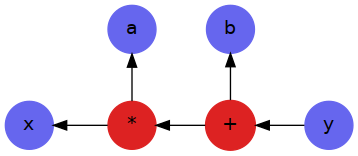

$y = ax+b$

$\frac{\partial y}{\partial x} = a$

$\frac{\partial y}{\partial a} = x$

$\frac{\partial y}{\partial b} = 1$


## Automatic Differentiation in PyTorch

- PyTorch deals with numerical data, so we get numerical answers for
  the value of the derivative at specific input values
- To find the derivatives of a tensor, you have to tell pytorch it
  must keep track of the gradients in the graph using `requires_grad`
- Then, call `backward` on the final node in the computational graph
- The `grad` member of the tensor contains the computed derivative
  (gradient)


In [ ]:
import torch
x = torch.tensor([2.], requires_grad=True)
a = torch.tensor([3.])
b = torch.tensor([4.])
y = a*x + b
y.backward() # calculates the derivatives through the graph
y
x.grad # dy/dx = a (= 3)


tensor([3.])

### More complex example of differentiation

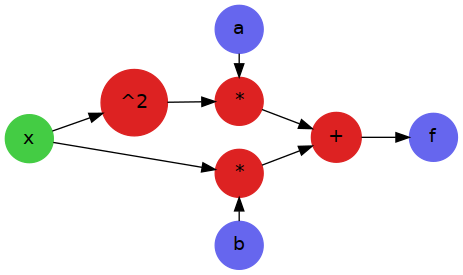

In [ ]:
os.system('cat Backward.dot | dot -Tpng > Backward.png')
Image('Backward.png')

In [ ]:
x = torch.tensor([2.], requires_grad=True)
a = torch.tensor([3.])
b = torch.tensor([2.])
f = a*x**2+b*x
f.backward()
x.grad # df / dx = 2ax + b = 2*3*2+2 = 14

tensor([14.])

- $f = bx + ax^2 \implies \frac{df}{dx} = b + 2ax$
- Here, there are two paths to get back to x from y
- The `grad_fn`'s ensure that all the paths are combined properly
  - So, `+` knows to sum along the 2 paths, etc.

You're not restricted to taking the derivative with a single variable,
it will calculate all needed variables in one pass,
just remember to `requires_grad` any node you will want the gradient from:

In [ ]:
x = torch.tensor([2.], requires_grad=True)
a = torch.tensor([3.], requires_grad=True)
b = torch.tensor([2.], requires_grad=True)
f = a*x**2+b*x
f.backward()
# df / dx = 2ax + b = 2*3*2+2 = 14
# df / da = x**2 = 4
# df / db = x = 2
x.grad, a.grad, b.grad


(tensor([14.]), tensor([4.]), tensor([2.]))

### Gradient accumulation

- Gradients will *accumulate* with each call to `backward()`
  - This is useful when doing stochastic gradient descent
- If we will want to clear the gradients, we can do it by hand
  - Note that in torch, fn's ending in "_" change the tensor *in
    place*, updating the existing tensor, rather than creating a new
    tensor

Without gradient clear:

In [ ]:
x = torch.tensor([2.], requires_grad=True) #require 부분 이해 안됨
a = torch.tensor([3.])
b = torch.tensor([2.])
f = a*x**2+b*x
f.backward() #backward 부분 이해 안된 어떻게 검색?
# df / dx = 2ax + b = 2*3*2+2 = 14
x.grad

# update the value of x
x.data = torch.tensor([1.])
f = a*x**2+b*x
f.backward()
# df / dx = 2ax + b = 2*3*1+2 = 8
x.grad
# the gradient has accumulated
? torch.tensor()

With gradient clear

In [ ]:
x = torch.tensor([2.], requires_grad=True)
a = torch.tensor([3.])
b = torch.tensor([2.])
f = a*x**2+b*x
f.backward()
# df / dx = 2ax + b = 2*3*2+2 = 14
x.grad
# clear the gradient manually
x.grad.data.zero_() 
# update the value of x
x.data = torch.tensor([1.])
f = a*x**2+b*x
f.backward()
# df / dx = 2ax + b = 2*3*1+2 = 8
x.grad



# The Basic Machine Learning Setup
- Lets make use of some of the machinery we've seen
- We have datapoints $(\vec{x}, y)$
- We posit (make the assumption) that the $\vec{x}$ can *predict* $y$
  - Note $y$ could represent a real number or a category
- We develop or assume some *model* $f$ gives the relationship between
  $\vec{x}$ and $y$, sans random errors that we can't control/model
- Typically, the model is *parameterised* by *parameters* $\vec{w}$,
  we write $f = f(\vec{x};\vec{w})$
  - This means that there is a whole space of models, we pick a
    particular model by choosing $\vec{w}$, which then gives a $y$ for each $\vec{x}$
- The goal of machine learning is to pick the "best" model from the space for some given data
  $(\vec{x_i}, y_i), i \in \{1, \ldots n\}$, which is equivalent to finding some *specific* $\hat{\vec{w}}$
  - We use hat $\hat{~}$ to denote "the best" for some definition of best
- "The best" usually means the values $\hat{\vec w}$ that minimize some
  *loss function* $L = L(\vec x, \vec y;\vec w)$, so that $\hat{\vec w} = \arg\min_{\vec{w}} L(\vec x, \vec y;\vec w)$
  - For instance, $L$ could be the mean squared error between the model $f(\vec x; \vec w)$ and the measured result $\vec y$
    $L = \frac{1}{n}\sum_i (f(\vec x_i;\vec w)-y_i)^2$



# Simple Linear Regression <a id="linear" />

- Let's start with a basic model, simple linear regression
- You posit a linear relation between a single input variable $x$,
  and the output, $y$
  - $y_i = \beta x_i + \alpha + \epsilon_i$
- Given a simple model, it (usually) won't be able to explain all the
  variance, $\epsilon_i$ represents the *residual*, meaning the bit left over
  - Residual: error term for factors not accounted for by the model
- For $x_i$ with unknown $y$, we would use the model to make a
  prediction: $y_i \approx f(x_i; \beta, \alpha) = \beta x_i + \alpha$
- The best model will minimize the size of the residual
  - Or rather, minimize the sum of the square of the residuals $\sum_i \epsilon^2_i$
  - In the language of the image below, we want to find the line which minimizes the size of the boxes
  - The line is parameterized the the intercept and gradient they are the $\vec w$, the datapoints are treated as fixed inputs, they are the $(\vec x,\vec y)$ inputs
- We *could* solve this analytically (the formula was given last
  week), but we want to try doing this in pytorch, using the
  technology we've seen
- We will implement a basic gradient descent

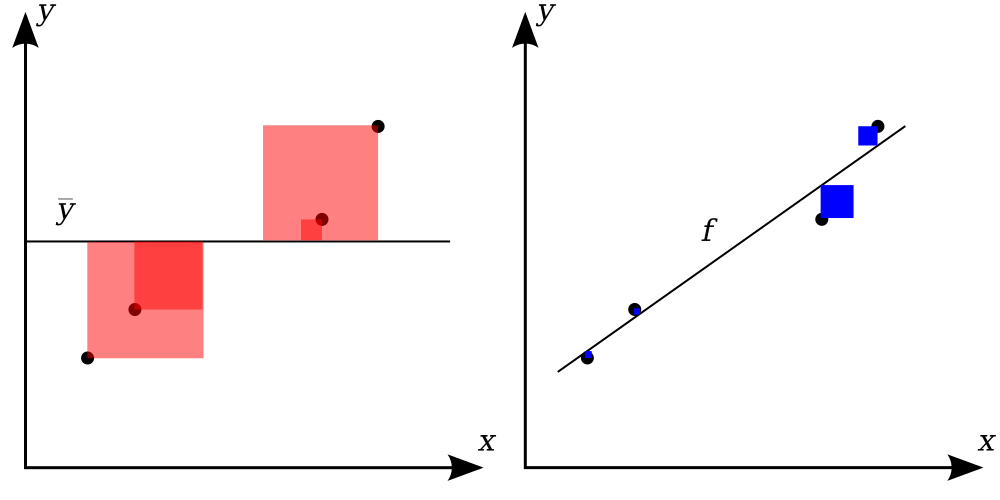

In [ ]:
Image('CoeffDet.png')

## (Stochastic) Gradient Descent

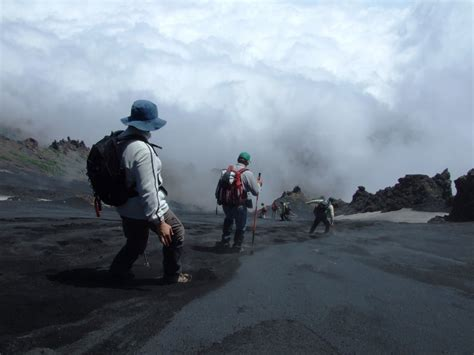

In [ ]:
Image('steepest_descent.jpg')

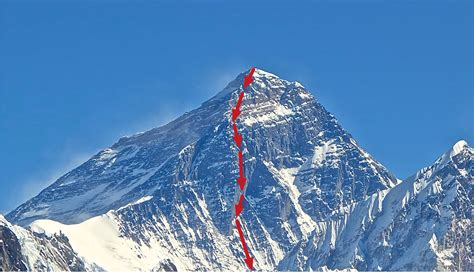

In [ ]:
Image('steepest_descent.jpg'); 

steps don't improve the loss function??

- Imagine your on a mountain and want to find your way down
  - You could start by finding the steepest sloping point down
  - Take a step in that direction
  - Repeat until your down the mountain (or stuck in a valley....)
- In gradient descent, we find a minima by
  - Starting at a random point in the parameter space $\vec{w}$
  - Taking the gradient of the loss function (the steepest path in
    parameter space at a given point)
  - "Taking a step" in the opposite direction of the gradient, i.e. go
    "downhill", $\vec{w} \leftarrow \vec{w} - \lambda {\nabla_\vec{w}} L$
  - Repeat until we converge (steps don't improve the loss function)
- The full loss function is (usually) a sum of the datapoints
- Then ${\nabla_\vec{w}} L$ will also be a sum over the datapoints
- We can take also take a subset of datapoints, and calculate the gradient and
  update on a "mini-batch"
  - Usually, theres thousands or millions of datapoints, so taking a step only after computing the full sum is too costly
- This is called stochastic gradient descent SGD
- SGD means we approximate the full loss (the sum over all datapoints)
  by ranging i over a random subset (it could even just be one
  datapoint)


## Verbose Implementation in PyTorch

- Find the coefficients $\alpha$ and $\beta$ that best fits $y=\alpha + \beta x$ for datapoints (1,2),
  (1.5,3.05), (2,3.95) using stochastic gradient descent with a mean-square error loss
  - $L = \sum_i (y_i - f(x_i))^2$ where $f(x_i, \alpha, \beta) = \alpha + \beta x_i$


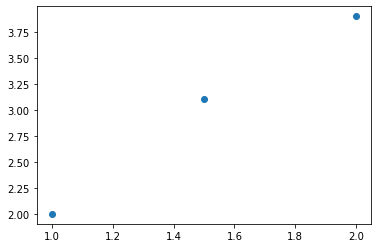

In [ ]:
import torch
import matplotlib.pyplot as plt
xs = torch.tensor([ [1.], [1.5], [2.]]) # datapoints
ys = torch.tensor([  2. ,  3.1 ,  3.9]) # as torch tensors
plt.scatter(xs,ys)

In [ ]:
# f(x) = alpha+beta*x; need to randomly initialize alpha & beta to *some* value
beta = torch.tensor([1.5], requires_grad=True)
alpha = torch.tensor([0.2], requires_grad=True)
lmbda = torch.tensor(0.02) # scaling factor for updating #무슨소리얔ㅋ
model = lambda x: beta*x+alpha # calculate the linear function

print(f"True  : {ys[0].item():.2f}, {ys[1].item():.2f}, {ys[2].item():.2f}") #문자열 만들기 +item? 
print(f"Before: {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
for times in range(5):
  for x_data, y_data in zip(xs, ys):
    alpha.grad, beta.grad = None, None # clear the gradient
    y_model = model(x_data) # calculate the function
    Loss = torch.pow(y_data-y_model, 2.) # calculate the loss for the point
    Loss.backward() # calculate and accumulate the gradient
    # Update using the gradient, step in the *opposite* direction
    beta.data = beta - lmbda*beta.grad
    alpha.data = alpha - lmbda*alpha.grad #그러면 맨 처음 베타와 알파 데이터는 임의값?
print(f"After : {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
print(f"Parameter Values: alpha={alpha.item():.2f}, beta={beta.item():.2f}")


True  : 2.00, 3.10, 3.90
Before: 1.70, 2.45, 3.20
After : 2.08, 2.95, 3.82
Parameter Values: alpha=0.35, beta=1.74


## Implementation in PyTorch: Some remarks
- Of course, this is just for illustration, pytorch has several helper
  functions to wrap up a lot of this detail, we'll cover them later
- Can trivially extend to multiple input variables:
  - $f(\vec{x}) = \alpha + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n$
- Also, as mentioned last week there is a closed form solution to the
  linear regression problem: $X \beta = y$ is $\beta = (X^TX)^{-1} X^T
  y$, where $X$ is a matrix where each row is an input datapoint with
  the corresponding data output in $y$, and $\beta$ is a vector of the
  model parameters
  - To take care of an arbitrary offset, add an additional column of 1s to the $X$ matrix
- In general though, our models will be more complex without nice closed form solutions

### Loss function

- To train a network, we need a function to minimize, a *loss* function
- There are many loss functions built-in to pytorch, some useful ones:
  - `MSELoss` : mean-square error loss, useful for regression and
    similar, which is what we used for the linear regression above
  - `BCELoss` : binary cross-entropy loss, for classifying a single
    output for on-off/yes-no conditions, it returns **-log(output)** if
    the result should be 1, **-log(1-output)** if the result should be 0
    - This derives from a likelihood anaylsis of the binomial distribution
  - `CrossEntropyLoss` : cross-entropy loss, for classifying into
    multiple categories using a one-hot encoding scheme,
    **-log(output[correct position])**
- They have the common form `loss_fn(prediction, true_values)`
  - `prediction` is the network output for a batch, `true_values` are
    the corresponding truth labels

In [ ]:
# some model of some classifiction process. sigmoid ensures the value is in the range [0,1]
# we will talk more about this next week
model = lambda a: torch.sigmoid(a[:,0]+2*a[:,1])
loss_fn = torch.nn.BCELoss() # the losses live in torch.nn
out = model(torch.zeros(1,2)) # the net is on the GPU
loss = loss_fn(out, torch.tensor([1.])) # one datapt
print(loss.item(), -torch.log(out).item()) # theres no magic

0.6931471824645996 0.6931471824645996


### Optimizers

- There are also built in optimizers, that automate most of the
  book-keeping required, and implement more advanced SGD update strategies
  - Adagrad, Adam, RMSProp, etc.
  - These are mostly ways of choosing the $\lambda$ parameter, allowing it to change rather than keeping it fixed, as well as implementing
    *momentum*
- The idea is that you give them the parameters they should keep track of
  when you initialize them, then calculate a `loss.backward()`
  (accumulating many times if you like), then call the `step()` function to
  update the parameters
- They live in the `torch.optim`
- The `optim.SGD` implements the same Stochastic Gradient Descent functionality as we wrote above, takes the learning rate as a parameter `lr`

In [ ]:
import torch.optim as optim
# create a basic stochastic gradient descent optimizer, pass in the parameters of our linear regression task
?optimizer = optim.SGD([alpha, beta], lr=0.005)

Object `optimizer` not found.


### Rewrite the SGD to use the PyTorch functions

- Lets rewrite the previous linear regression with SGD to use the built-in pytorch options
- You can see it simplifies the code, but also note that we get the same result, there's no magic here
- Can also see the `.grad` code is all hidden behind the optimizer, no need to explicitly call it here
- Make sure you understand exactly what each line of code is doing, this is the basic Pytorch training loop we will implement again and again

In [ ]:
xs = torch.tensor([ [1.], [1.5], [2.]]) # datapoints
ys = torch.tensor([ [2.], [3.1], [3.9]]) # as torch tensors
# f(x) = alpha+beta*x
beta = torch.tensor([1.5], requires_grad=True)
alpha = torch.tensor([0.2], requires_grad=True)

opt = optim.SGD([alpha, beta], lr=0.02)
f_loss = torch.nn.MSELoss() # mean square error loss (y_true-y_pred)**2

model = lambda x: beta*x+alpha # calculate the linear function

print(f"True  : {ys[0].item():.2f}, {ys[1].item():.2f}, {ys[2].item():.2f}")
print(f"Before: {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
for times in range(5): # we call one time through the data an "epoch", so we here are "running 5 epochs"
    for x_data, y_data in zip(xs, ys):
        opt.zero_grad() # clear the gradient
        y_model = model(x_data) # calculate the function
        loss = f_loss(y_data,y_model) # calculate the loss for the point
        loss.backward() # calculate and accumulate the gradient
        # Update using the gradient, step in the *opposite* direction
        opt.step()
print(f"After : {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
print(f"Parameter Values: alpha={alpha.item():.2f}, beta={beta.item():.2f}")

True  : 2.00, 3.10, 3.90
Before: 1.70, 2.45, 3.20
After : 2.08, 2.95, 3.82
Parameter Values: alpha=0.35, beta=1.74


### One last example: full loss instead of one datapoint at a time

The models and loss functions can take several datapoints at once. By default, they return the *average* loss

In [ ]:
xs = torch.tensor([ [1.], [1.5], [2.]]) # datapoints
ys = torch.tensor([ [2.], [3.1], [3.9]]) # as torch tensors
# f(x) = alpha+beta*x
beta = torch.tensor([1.5], requires_grad=True)
alpha = torch.tensor([0.2], requires_grad=True)

opt = optim.SGD([alpha, beta], lr=0.02)
f_loss = torch.nn.MSELoss() # mean square error loss (y_true-y_pred)**2, by default averages over the batch

model = lambda x: beta*x+alpha # calculate the linear function

print(f"True  : {ys[0].item():.2f}, {ys[1].item():.2f}, {ys[2].item():.2f}")
print(f"Before: {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
for times in range(5): # we call one time through the data an "epoch", so we here are "running 5 epochs"
        opt.zero_grad() # clear the gradient
        y_model = model(xs) # calculate the function
        loss = f_loss(ys,y_model) # calculate the loss for the point
        loss.backward() # calculate and accumulate the gradient
        # Update using the gradient, step in the *opposite* direction
        opt.step()
print(f"After : {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
print(f"Parameter Values: alpha={alpha.item():.2f}, beta={beta.item():.2f}")

True  : 2.00, 3.10, 3.90
Before: 1.70, 2.45, 3.20
After : 1.92, 2.74, 3.56
Parameter Values: alpha=0.28, beta=1.64


# Exercises <a id="exercises" />

The exercises go through some examples of calculating derivatives, and
introduce particle tracking detectors, an example we will return to later in the course.

Find the derivate $dy/dx$ of $y(x) = \exp(1. / \tan(\log(x+1)))$ at $x=3$
(using pytorch of course)

In [ ]:
import torch as th
import numpy as np
import torch.optim as optim

x1 = th.tensor([3.], requires_grad=True)
f1 = th.exp(1./th.tan(th.log(x1+1)))
f1.backward()
x1.grad

tensor([-0.3118])

You can calculate multiple gradients by passing a vector, of the same
size as the input you want to calculate the gradient of, to the
backward function. An example should show you what I mean:

In [ ]:
x = th.tensor([-3,-2,1,0,1.,2.,3.], requires_grad=True)
y = x**2
y.backward(th.ones_like(x)) # calculate the gradient separately for each x
x.grad
#torch.zeros_like(x)

tensor([-6., -4.,  2.,  0.,  2.,  4.,  6.])

We need the `ones_like` function (which creates a tensor the same
shape as the input, but filled with 1), because torch will multiply
the values passed to the gradient output, and here we just want the
gradient values.
Now plot $dy/dx$ of $y=\exp(1/\tan(\log(x+1)))$ for x between 1 and 3. Use
enough points to get a smooth curve. You will have to `detach()` the
tensor from the computational graph in order to use it outside of
torch (i.e. when passing to matplotlib)

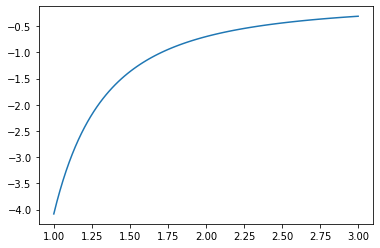

In [ ]:
import matplotlib.pyplot as plt # standard way to import
import numpy as np

import torch as th

x1 = th.tensor(np.linspace(1.0,3.0,100), requires_grad=True)
f1 = th.exp(1./th.tan(th.log(x1+1)))

f1.backward(th.ones_like(x1))
x1.grad

f2 = x1.grad.detach().numpy()
x1 = th.tensor(np.linspace(1.0,3.0,100), requires_grad=True).detach().numpy()

# # x2 = th.tensor([0,1.,2.,3.], requires_grad=True)
# # f2 = th.exp(1./th.tan(th.log(x2+1))).detach().numpy()
# # x2 = th.tensor([0,1.,2.,3.], requires_grad=True).detach().numpy()

plt.plot(x1, f2)


Copy and rerun the basic SGD implementation (final, full pytorch) from the lecture notes, turn the number of *epochs* up from 5, enough so that additional epochs don't affect the result (i.e. until the result has *converged*), what is the value of the parameters after the model has converged?

In [ ]:
xs = torch.tensor([ [1.], [1.5], [2.]]) # datapoints
ys = torch.tensor([ [2.], [3.1], [3.9]]) # as torch tensors
# f(x) = alpha+beta*x
beta = torch.tensor([1.5], requires_grad=True)
alpha = torch.tensor([0.2], requires_grad=True)

opt = optim.SGD([alpha, beta], lr=0.02)
f_loss = torch.nn.MSELoss() # mean square error loss (y_true-y_pred)**2

model = lambda x: beta*x+alpha # calculate the linear function

print(f"True  : {ys[0].item():.2f}, {ys[1].item():.2f}, {ys[2].item():.2f}")
print(f"Before: {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
for times in range(2000): # we call one time through the data an "epoch", so we here are "running 5 epochs"
    for x_data, y_data in zip(xs, ys):
        opt.zero_grad() # clear the gradient
        y_model = model(x_data) # calculate the function
        loss = f_loss(y_data,y_model) # calculate the loss for the point
        loss.backward() # calculate and accumulate the gradient
        # Update using the gradient, step in the *opposite* direction
        opt.step()
print(f"After : {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
print(f"Parameter Values: alpha={alpha.item():.2f}, beta={beta.item():.2f}")

True  : 2.00, 3.10, 3.90
Before: 1.70, 2.45, 3.20
After : 2.05, 3.00, 3.94
Parameter Values: alpha=0.16, beta=1.89


# converged alpha=0.16, beta=1.89 #Question example 2개 차이

Now, try with a larger learning rate $\lambda$. What happens if you turn
$\lambda$ up too high?

In [ ]:
xs = th.tensor([ [1.], [1.5], [2.]]) # datapoints
ys = th.tensor([ [2.], [3.1], [3.9]]) # as torch tensors
# f(x) = alpha+beta*x
beta = th.tensor([1.5], requires_grad=True)
alpha = th.tensor([0.2], requires_grad=True)

opt = optim.SGD([alpha, beta], lr=1.0)
f_loss = th.nn.MSELoss() # mean square error loss (y_true-y_pred)**2

model = lambda x: beta*x+alpha # calculate the linear function

print(f"True  : {ys[0].item():.2f}, {ys[1].item():.2f}, {ys[2].item():.2f}")
print(f"Before: {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
for times in range(5): # ? epoch
    for x_data, y_data in zip(xs, ys): #batch size = 1
        opt.zero_grad() # clear the gradient
        y_model = model(x_data) # calculate the function
        loss = f_loss(y_data,y_model) # calculate the loss for the point
        loss.backward() # calculate and accumulate the gradient
        # Update using the gradient, step in the *opposite* direction
        opt.step()
print(f"After : {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
print(f"Parameter Values: alpha={alpha.item():.2f}, beta={beta.item():.2f}")

True  : 2.00, 3.10, 3.90
Before: 1.70, 2.45, 3.20
After : 10151630848.00, 13556277248.00, 16960923648.00
Parameter Values: alpha=3342337536.00, beta=6809292800.00


# alpha=nan, beta=nan model can't find parameter value

Turn the stochastic gradient descent code into a full gradient
descent. Instead of updating with each datapoint, let the gradient
accumulate and update only after you ran through the entire dataset
(careful where you clear the gradients). Does it change the result in
this case?

In [ ]:
xs = th.tensor([ [1.], [1.5], [2.]]) # datapoints
ys = th.tensor([ [2.], [3.1], [3.9]]) # as torch tensors
# f(x) = alpha+beta*x
beta = th.tensor([1.5], requires_grad=True)
alpha = th.tensor([0.2], requires_grad=True)

opt = optim.SGD([alpha, beta], lr=0.02)
f_loss = th.nn.MSELoss() # mean square error loss (y_true-y_pred)**2

model = lambda x: beta*x+alpha # calculate the linear function

print(f"True  : {ys[0].item():.2f}, {ys[1].item():.2f}, {ys[2].item():.2f}")
print(f"Before: {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
for times in range(5): # we call one time through the data an "epoch", so we here are "running 5 epochs"
    for x_data, y_data in zip(xs, ys):
        opt.zero_grad() # clear the gradient
        y_model = model(x_data) # calculate the function
        loss = f_loss(y_data,y_model) # calculate the loss for the point
        loss.backward() # calculate and accumulate the gradient
        # Update using the gradient, step in the *opposite* direction
        
        opt.step()
print(f"After : {model(1).item():.2f}, {model(1.5).item():.2f}, {model(2).item():.2f}")
print(f"Parameter Values: alpha={alpha.item():.2f}, beta={beta.item():.2f}")

True  : 2.00, 3.10, 3.90
Before: 1.70, 2.45, 3.20
After : 2.08, 2.95, 3.82
Parameter Values: alpha=0.35, beta=1.74


## The stochastic gradient descent learn faster than the full gradient descent on the same learning rate and epochs

"The stochastic gradient descent learn faster than the full gradient descent on the same learning rate and epochs"

Calculate the answer with the $\beta$ formula from last week's
lecture. Compare your SGD results with the analytic solution.

In [ ]:
import torch
import matplotlib.pyplot as plt
xs = torch.tensor([ [1.], [1.5], [2.]]) # datapoints
ys = torch.tensor([ [2.], [3.1], [3.9]]) # as torch tensors

X = torch.cat((torch.ones(3,1), xs), axis=1) #column vectror가  되는거 어케 알어
print(X.shape)
beta=torch.matmul(torch.matmul(torch.matmul(X.t(),X).inverse(),X.t()),ys)
print(beta)



torch.Size([3, 2])
tensor([[0.1500],
        [1.9000]])


In [ ]:
# SGD result converged alpha=0.16, beta=1.89 
# analytic solution. alpha=0.15, beta=1.9 

## Particle Tracking

For a more physics example, lets find the momentum of charged
particles passing through a tracking detector. In particle physics
detectors, like CMS at the LHC, we have a particle collision at the
center of the detector, and the collision point is surrounded by a
series of concentric cylindrical silicon detector immersed in a
magnetic field, which is used to see the path of charged particles
(which ionize and cause a current in the silicon detectors). You can
see the silicon detectors (rectangular blocks) in the photo. The
proton-proton collision point is in the center of the cylinder.


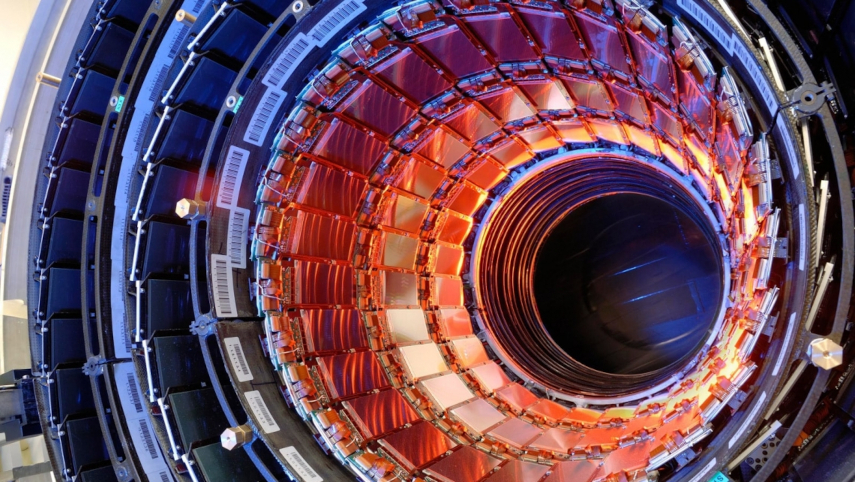

In [ ]:
Image("CMS_photo.jpg")

In a magnetic field, a charge particle will bend in propotion to its momentum,
so if we can see how far the particle bends, we can measure the momentum. The
following shows an x-y slice of CMS, concentrate on the "Silicon Tracker".

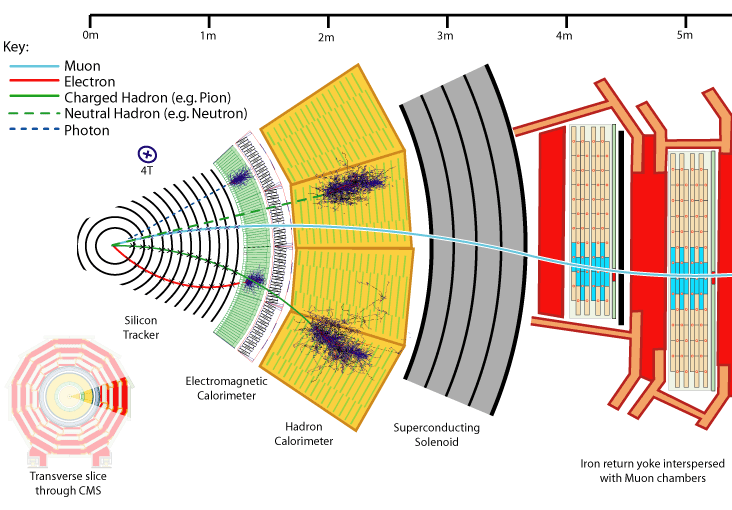

In [ ]:
Image('CMS_Slice-1.png')

If the B-field is constant in the z-direction, the particle will
travel in a circle, whose radius is given by $p=0.3 R B$ where
`p` is the momentum (in the x-y plane) in GeV, `R` is the radius
in meters, and `B` is the magnetic field strength in Tesla.

- Some slides with more of the derivation and explanation:
  - http://www2.fisica.unimi.it/andreazz/AA_TrackingSystems.pdf

So, for example, if we have a particle travelling from the origin
initially along the x axis, that hits discrete detector points,
we can write the following linking the (x,y) hit positions to `R`
(and thereby the momentum `p`).
$$(x,y) = (R\sin\theta, R(1-\cos{\theta}))$$
$$(\sin\theta, \cos\theta) = (x/R, (R-y)/R)$$
and then, using pythagoras:
$$1 = (x/R)^2 + (R-y)^2/R^2$$
and after a little bit of algebra:
$$(x^2+y^2)-2yR=0$$
So, if we find the $\hat{R}$ (the specific value of $R$, or an *estimate* for $R$ in statistical language) which gives the above expression
closest to 0 for every $(x,y)$ point the track leaves in
the detector, we can use $p=0.3RB$ to find the particles
momentum. We can take "closest to 0 for every $(x,y)$ point" to mean:
$$\hat{R} = \arg\min_R \sum_i |(x_i^2+y_i^2) - 2 y_i R|$$
that is, we should minimize the sum of the absolute value of
the expression with the sum taken over each point of the track.

Note, we don't expect each point to exactly satisfy the equation because
of the finite resolution of the detector, and multiple scattering as
the particle passes through the detector which slightly deviates the momentum.

The ACTS code can be used to simulate a simple tracking detector.  I
simulated the setup above with ACTS, i.e. firing a particle, a muon, from the
origin with momentum in the x-direction. I put the result (particle
hits in the detector) online in a csv file which we can read in and take a look at:

- ACTS, A Common Tracking Software, https://github.com/acts-project/acts

(rerun the cell to make sure you load the data and it plots okay)

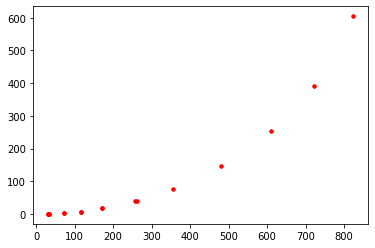

In [1]:
import csv
import requests
import io
import numpy as np
import matplotlib.pyplot as plt
r = requests.get('https://cernbox.cern.ch/index.php/s/cGW3njNCdSj45bs/download')
reader = csv.reader(io.StringIO(r.text), delimiter=',')
header = None
datapoints = []
for row in reader:
    if header is None: header = row
    else:
        row = {h:v for h,v in zip(header, row)}
        x, y = row['tx'], row['ty']
        datapoints.append((float(x),float(y)))
datapoints = np.array(datapoints)
plt.scatter(datapoints[:,0],datapoints[:,1], s=12, color='red')


We have a nice circular track which started from the origin. Note the particle bends in the counter clockwise direction as its negatively charged.

Using pytorch and the SGD optimizer, find the $R$ which minimizes the above expression for this dataset,
and then find the momentum of the particle using $p=0.3RB$. Note that ACTS expresses its units in mm,
while the equation expects R in meters. Draw the predicted path and the datapoints on the same plot.

Did you get a nice result? (i.e. does the predicted path match the datapoints?)

Parameter Values: Ra = 2023.96mm
p = 0.3xRxB = 2.4287 GeV


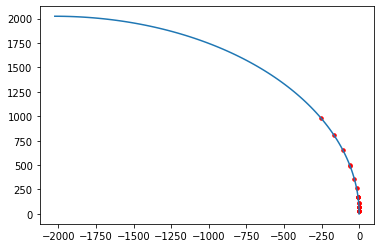

In [34]:
import torch
import torch.optim as optim
import csv
import requests
import io
import numpy as np
import matplotlib.pyplot as plt


r = requests.get('https://cernbox.cern.ch/index.php/s/bnlZ6Q6yD0n5EIX/download')
reader = csv.reader(io.StringIO(r.text), delimiter=',')
header = None
datapoints = []
for row in reader:
    if header is None: header = row
    else:
        row = {h:v for h,v in zip(header, row)}
        x, y = row['tx'], row['ty']
        datapoints.append((float(x),float(y)))
datapoints = np.array(datapoints)

xs = torch.tensor(datapoints[:,0])
ys = torch.tensor(datapoints[:,1])

Ra = torch.tensor([10.], requires_grad=True)

opt = optim.SGD([Ra], lr=0.000002)
f_loss = torch.nn.MSELoss() # mean square error loss (y_true-y_pred)**2, by default averages over the batch

model = lambda x, y: x*x + y*y + 2*x*Ra

for times in range(50): # 
    opt.zero_grad() # clear the gradient
    y_model = model(xs, ys) # calculate the function
    loss = f_loss(torch.zeros_like(y_model),y_model) # calculate the loss for the point
    loss.backward() # calculate and accumulate the gradient
    opt.step() # Update using the gradient, step in the *opposite* direction

print(f"Parameter Values: Ra = {Ra.item():.2f}mm")
print(f"p = 0.3xRxB = {0.3*Ra.item()*0.001*4:.4f} GeV")

theta = np.linspace(0, np.pi/2, 100)
plt.scatter(xs, ys, s=12, color='red')
plt.plot(-Ra.detach()*(1-np.cos(theta)), Ra.detach()*np.sin(theta))

There is a second dataset at:
https://cernbox.cern.ch/index.php/s/bnlZ6Q6yD0n5EIX/download
This particle (also a muon) was fired in the positive y direction.

Derive the equivalent expression which we need to minimize (be careful of minus signs! the particle will bend into the negative x direction!), find the particle momentum,
and draw the estimated path. That is, do the previous exercise again with the new dataset, and the expression to minimize replaced by the one you derive. [If you're having trouble understanding the setup, start by plotting the datapoints!]

In a proper tracking setup, we would of course also fit the direction of initial travel as well as the radius of the particle in the magnetic field. (That is, we will return to this dataset later in the course!)
